In [57]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import timeit 
import torch.nn.functional as F
from tqdm import tqdm
import cv2

In [58]:
#!pip install sporco
#!pip install segyio
from sporco import array,plot,util
import segyio

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Load poststack image**

In [60]:
segyfile = 'datasets/real_stack.segy'

f = segyio.open(segyfile, ignore_geometry=True)

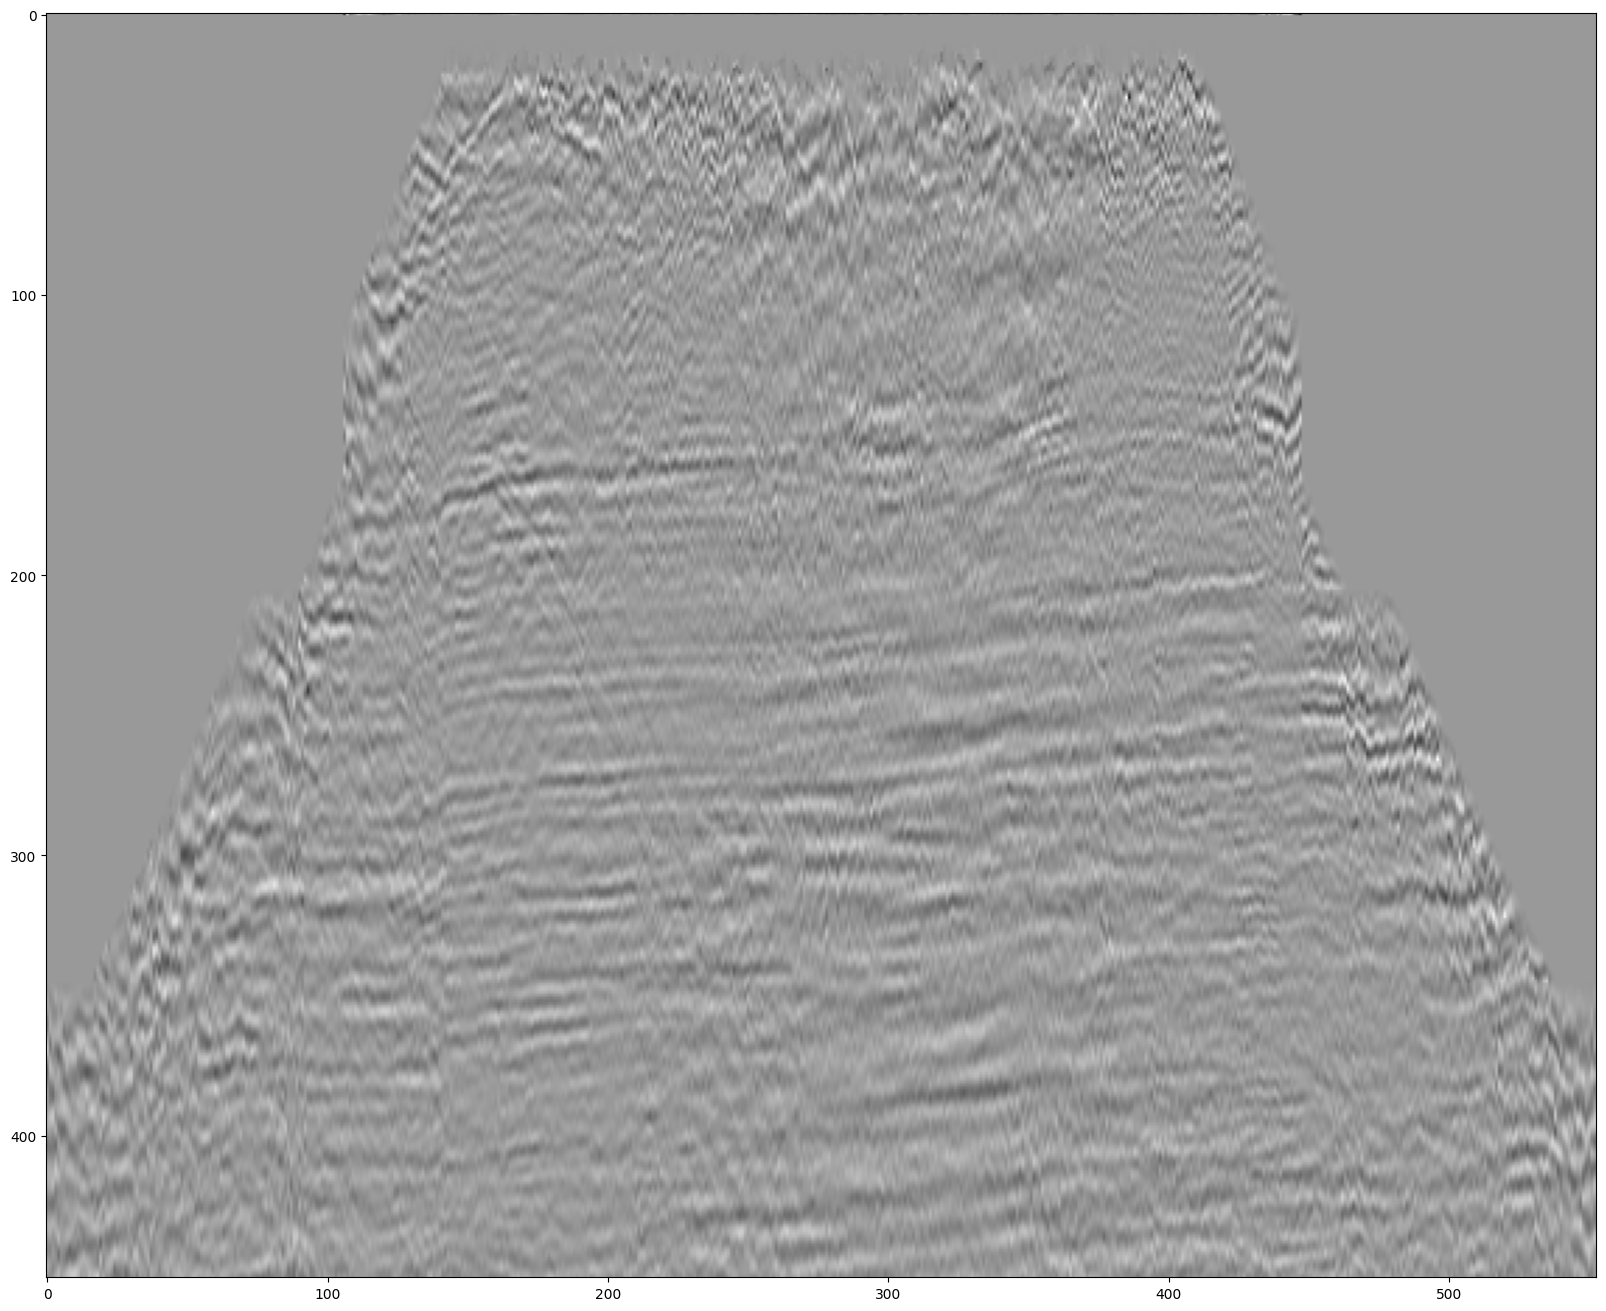

In [61]:
figsize=(20, 20)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize, facecolor='w', edgecolor='k',
                       squeeze=False,
                       sharex=True)
axs = axs.ravel()
im = axs[0].imshow(f.trace.raw[:].T, cmap="gray")


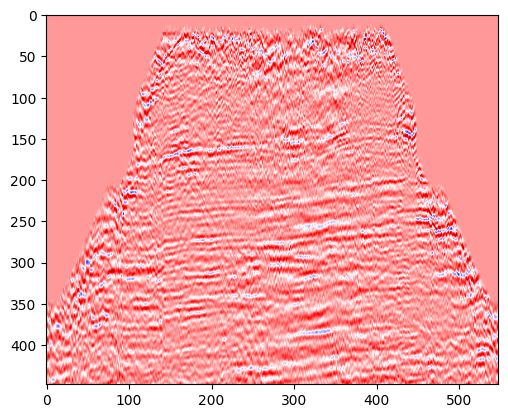

In [62]:
TestData = f.trace.raw[:].T
TestData = TestData[:TestData.shape[0]-3,:TestData.shape[1]-5]
TestData = (TestData - np.min(TestData))/(np.max(TestData) - np.min(TestData))
plt.imshow(TestData, cmap='seismic' ),plt.clim([0,1])
plt.show()

In [63]:
TestData.shape

(448, 548)

In [64]:
'''
right =TestData.shape[0]%128
top = TestData.shape[1]%128
print(right)
print(top)
mask = np.zeros([TestData.shape[0]+61,  TestData.shape[1]+87]).astype(dtype='float32')
print(mask.shape)
mask[30:mask.shape[0]-31,  43:mask.shape[1]-44] = TestData[:,:]
print(mask.shape)
plt.imshow(mask)
plt.show()
'''

"\nright =TestData.shape[0]%128\ntop = TestData.shape[1]%128\nprint(right)\nprint(top)\nmask = np.zeros([TestData.shape[0]+61,  TestData.shape[1]+87]).astype(dtype='float32')\nprint(mask.shape)\nmask[30:mask.shape[0]-31,  43:mask.shape[1]-44] = TestData[:,:]\nprint(mask.shape)\nplt.imshow(mask)\nplt.show()\n"

In [65]:
5*128-553

87

In [66]:
singleffid = TestData.copy()
blksz = (128,128)
stpsz = (20,20)
blcks_corrupt = array.extract_blocks(singleffid, blksz, stpsz)
blcks_non_corrupt = array.extract_blocks(TestData, blksz, stpsz)

In [67]:
subblcks_corrupt = blcks_corrupt.transpose(2,0,1)
subblcks_non_corrupt = blcks_non_corrupt.transpose(2,0,1)
subblcks_non_corrupt = torch.from_numpy(subblcks_non_corrupt).unsqueeze(1)
subblcks_corrupt = torch.from_numpy(subblcks_corrupt).unsqueeze(1)

**Import model and load weigths**

In [68]:
from models.Attention_unet import AttU_Net

In [69]:
model = AttU_Net(img_ch=1,output_ch=1).to(device)
model.eval()
model.load_state_dict(torch.load('checkpoints/att_u_fine.pt'))

<All keys matched successfully>

In [70]:
subblcks_corrupt.shape

torch.Size([374, 1, 128, 128])

**EXP 2 : RECONSTRUCTION POSTSTACK IMAGE**

In [71]:
data_loader = torch.utils.data.DataLoader(subblcks_corrupt, batch_size=40)

In [72]:
denoised_tensor_list = []
for batch in tqdm(data_loader):
    with torch.no_grad():
        denoised_batch = model(batch.to(device))
        denoised_tensor_list.append(denoised_batch.cpu())
recov_blcks = torch.cat(denoised_tensor_list, dim=0)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.42it/s]


In [73]:
recov_blcks = recov_blcks.numpy().transpose(0,2,3,1)
subblcks_corrupt = subblcks_corrupt.numpy().transpose(0,2,3,1)
subblcks_non_corrupt = subblcks_non_corrupt.numpy().transpose(0,2,3,1)

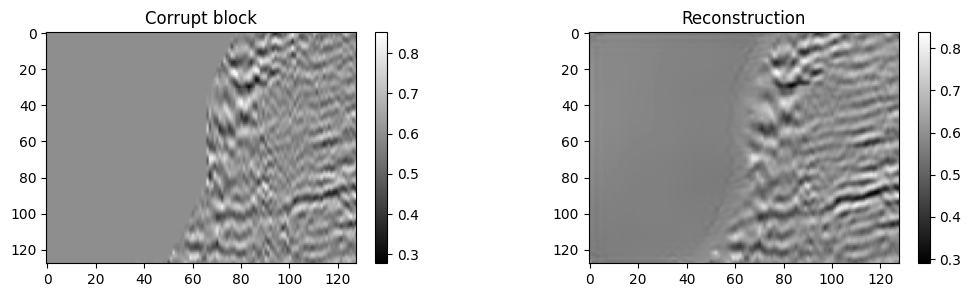

In [74]:
kk =90
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(subblcks_corrupt[kk,:,:,0],aspect='auto',cmap='gray'), #plt.clim([0.5,0.64])
plt.colorbar()

plt.title("Corrupt block")

plt.subplot(122)
plt.imshow(recov_blcks[kk,:,:,0],aspect='auto',cmap='gray'), 
plt.colorbar()
plt.title("Reconstruction")


plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [75]:
del denoised_tensor_list

In [76]:
Urec  = recov_blcks.squeeze().transpose(1,2,0)
Urec = Urec.reshape(np.product(blksz), -1)

In [77]:
start = timeit.default_timer()
#imgd_median = array.average_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz)
imgd_median = array.combine_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz, np.median)
print("creating image from patching, time is:",
              timeit.default_timer() - start)

creating image from patching, time is: 6.825156300000003


In [78]:
imgd_median.shape

(448, 548)

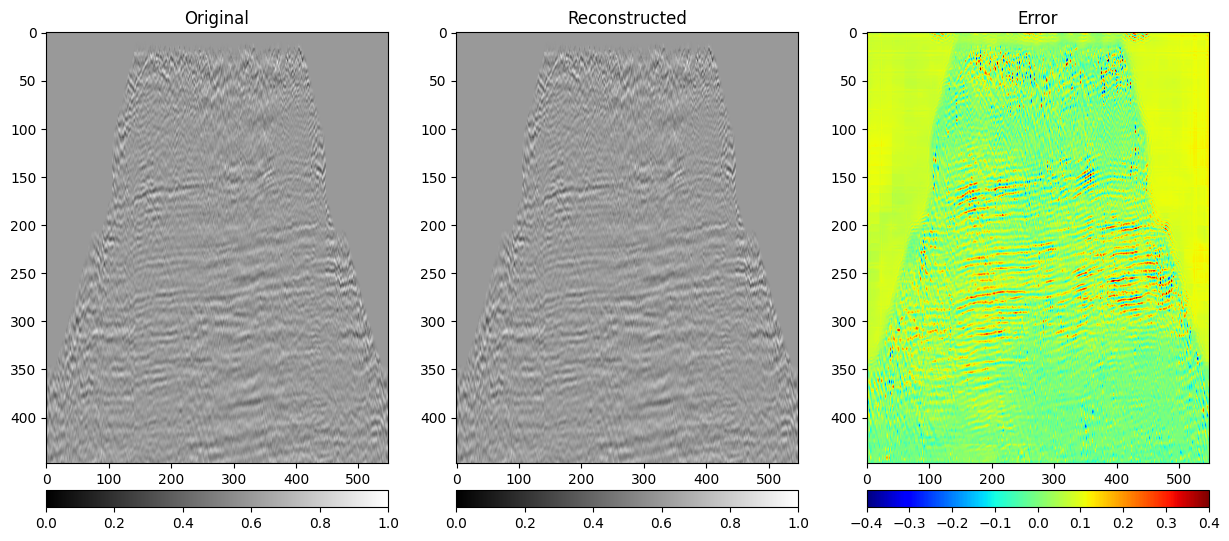

In [86]:
plt.figure(figsize=(15,7))

err = TestData-imgd_median
err /= np.max(np.abs(err))

plt.subplot(131)
plt.imshow(TestData,aspect='auto',cmap='gray')
plt.title('Original')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(132)
plt.imshow(TestData,aspect='auto',cmap='gray'), plt.clim([0,1])
plt.title('Reconstructed')
plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(133)
plt.imshow(err,aspect='auto',cmap='jet'),
plt.clim([-.4,.4])
plt.title('Error')
plt.colorbar(orientation='horizontal',pad=0.05)
plt.show()

**Section of the complete 2D reconstruction**

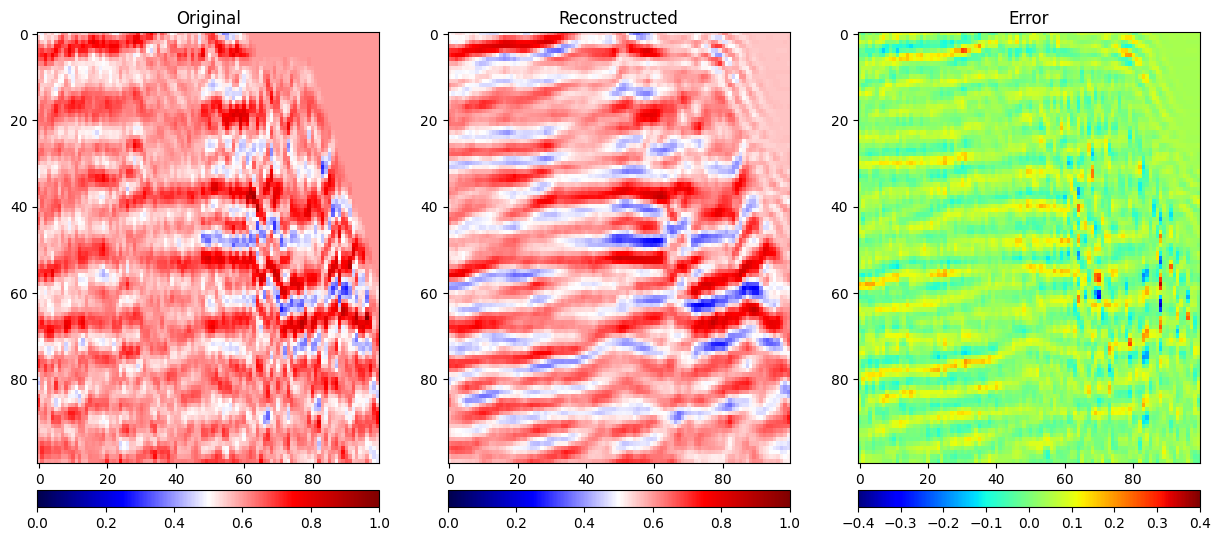

In [85]:
err_section = TestData[200:300,400:500]-imgd_median[200:300,400:500]

plt.figure(figsize=(15,7))
plt.subplot(131)
plt.imshow(TestData[200:300,400:500],aspect='auto',cmap='seismic')
plt.title('Original')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(132)
plt.imshow(imgd_median[200:300,400:500],aspect='auto',cmap='seismic'), plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.title('Reconstructed')
plt.subplot(133)
plt.imshow(err_section,aspect='auto',cmap='jet'),
plt.clim([-.4,.4])
plt.title('Error')
plt.colorbar(orientation='horizontal',pad=0.05)
plt.show()

In [84]:
import math
def estimate_noise(I):

  H, W = I.shape

  M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]
  I= torch.from_numpy(I).float()
  M=np.array(M)
  M=torch.from_numpy(M).float()
  imgFiltered = F.conv2d(I.unsqueeze(0).unsqueeze(0), M.unsqueeze(0).unsqueeze(0), padding=1)
  x=imgFiltered.numpy()
  sigma = np.sum(np.sum(np.absolute(x)))
  sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))

  return sigma
print("Noisy image:",estimate_noise(TestData))
print("Denoised image:",estimate_noise(imgd_median))

Noisy image: 0.005025481557040387
Denoised image: 0.0024643457765368224
